In [195]:
# load dataset 
import sys 
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_utils
import RS_models

In [196]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from albumentations import *
from torchvision import transforms
from torch.utils.data import DataLoader
from glob import glob
import segmentation_models_pytorch as smp

import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm 

import wandb
import logging
from tqdm import tqdm

In [197]:
#-- data
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

img_path_ship  = np.array(sorted(glob(os.path.join(img_path, "*.png"))) )
mask_path_ship = np.array(sorted(glob(os.path.join(mask_path, "*.png"))) )

aa = np.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Tasks/Segmentation_1/03.data_list/512_ships.npy")

selected_paths_img = img_path_ship[aa]
selected_paths_mask  = mask_path_ship[aa]

In [198]:
#---------------------------------
#-- args operation
EXEC_VER = 1 # zero means test 
DDP = False
TASK = "Seg"
#-- args data 
CROP_SIZE = 256
DATA_PATH_IMG = selected_paths_img
DATA_PATH_LABEL = selected_paths_mask
#-- args modeling 
MODEL_NAME = "Unet++"
MODEL_IN_CHANNEL = 3   # image channel  
MODEL_OUT_CHANNEL = 3  # mask channel and category 
CRITERION = "CE"
BATCH_SIZE = 8 # 4
LEARNING_RATE = 1e-4 #1e-5
#-- args train
DEVICE = "cuda:0"
DEVICES = [0,1,2,3]
RESUME = False
SAVE_EPOCH = 20
EPOCHS = 140
DATA_SHUFFLE = True
#-- args category 
ISAID_CLASSES_SHIP = (
    'background','ship','harbor' 
    )
ISAID_PALETTE_SHIP = {
    0: (0, 0, 0), 
    1: (0, 0, 63), 
    2: (0, 100, 155)
    }
#---------------------------------

In [199]:
#-- dataset
train_dataset = RS_dataset.Seg_RS_dataset_edge_v5(img_dir = DATA_PATH_IMG, 
                                                  mask_dir = DATA_PATH_LABEL, 
                                                  image_resize = None, 
                                                  crop_size = CROP_SIZE, 
                                                  phase = "train",
                                                  palette=ISAID_PALETTE_SHIP,
                                                  edge_return=False,
                                                  mask_onehot=True)


In [200]:
img,mask = train_dataset.__getitem__(np.random.randint(0,400))

In [201]:
mask.shape

torch.Size([3, 256, 256])

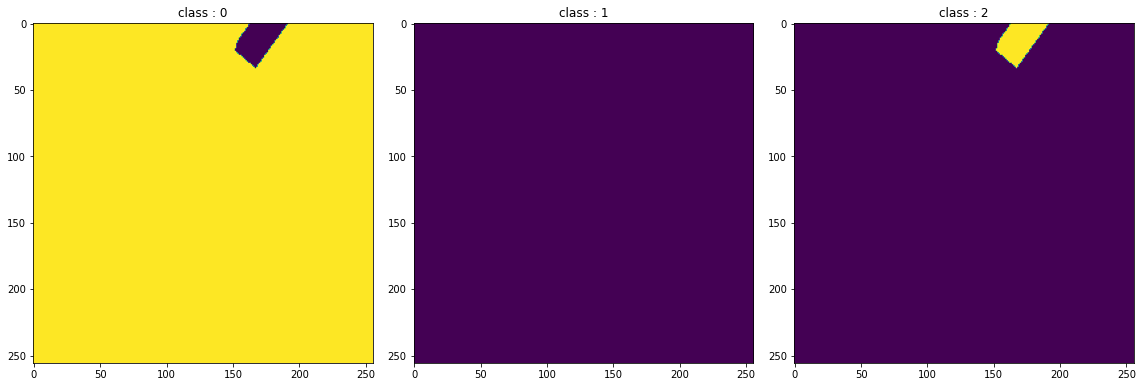

In [202]:
RS_utils.label_display(mask, n_class=3, nrows=1 , ncols=3, channel_order='torch', batch=False)

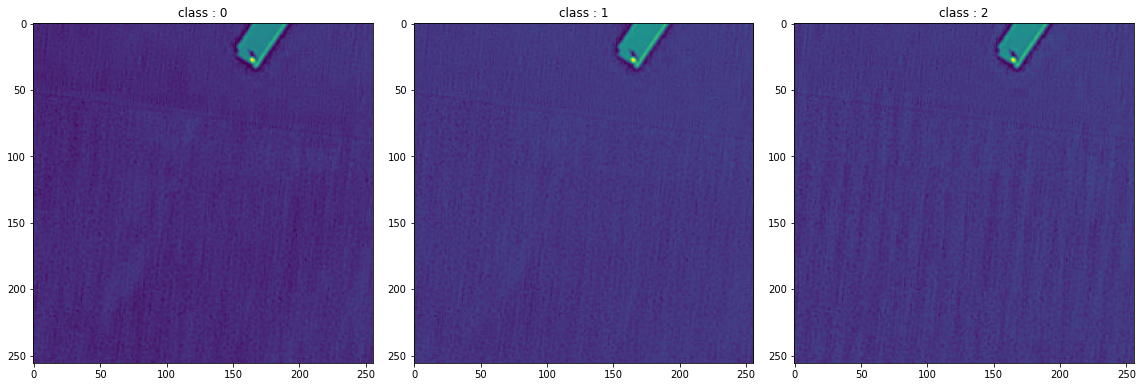

In [203]:
RS_utils.label_display(img, n_class=3, nrows=1 , ncols=3, channel_order='torch', batch=False)

In [204]:
aa = "./02.ckpts"

w_path = sorted(glob(os.path.join(aa, "*.pt")))[-1]
w_path ="/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Tasks/Segmentation_2/DATA_Ship_Seg/02.ckpts/ver_1_Seg_Unet++_epoch_21_iteration_393141.pt"
print(w_path)
weights_ = torch.load(w_path, map_location=torch.device('cpu'))

/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Tasks/Segmentation_2/DATA_Ship_Seg/02.ckpts/ver_1_Seg_Unet++_epoch_21_iteration_393141.pt


In [205]:
MODEL_OUT_CHANNEL

3

In [206]:
model = smp.UnetPlusPlus(encoder_name="resnet152",classes=MODEL_OUT_CHANNEL)
model.load_state_dict(weights_)
model = model.eval()

In [207]:
input_ = img.unsqueeze(0)
pred = model(input_)

In [208]:
pred.shape

torch.Size([1, 3, 256, 256])

In [209]:
pred_a = pred.detach().cpu()
pred_a = torch.argmax(pred_a,dim=1)

In [210]:
pred_a.shape

torch.Size([1, 256, 256])

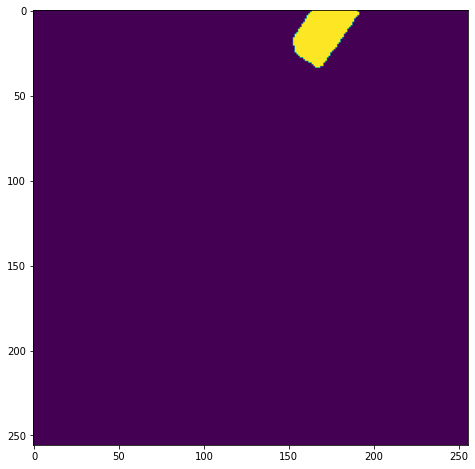

In [211]:
pred_a = pred_a.permute(1,2,0)
plt.figure(figsize=(8,8))
plt.imshow(pred_a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


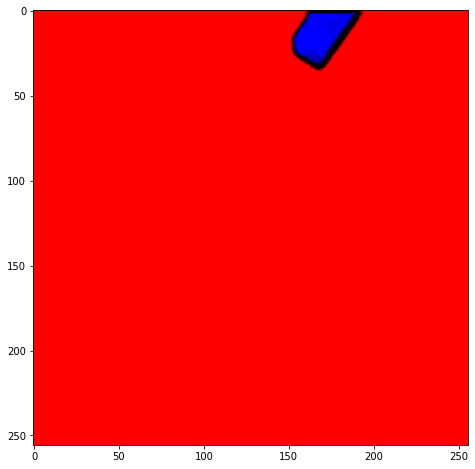

In [212]:
pred = pred[0,:]
pred = pred.detach().cpu()
pred = pred.permute(1,2,0)
plt.figure(figsize=(8,8))
plt.imshow(pred)

In [213]:
pred.shape

torch.Size([256, 256, 3])